# Ensembles and Random Forests
## Foundations of Machine Learning
## `! git clone https://github.com/DS3001/ensembles`

In [1]:
! git clone https://github.com/DS3001/ensembles


Cloning into 'ensembles'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 609.41 KiB | 2.47 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## Back to Machine Learning
- The point of the probability/bootstrap lectures was to introduce the idea and power of resampling
- Your data aren't just one set of data: They're a deep reservoir of information that can be used to quantify all kinds of uncertainty
- Can these principles be applied directly to solving machine learning problems? (Today is one version of an answer to that question)

## Decision Trees
- Let's look at the housing price data again, where we predict `sale_price` from a bunch of features of the property
- The original model looks fine: It uses a number of square footage variables, which seems reasonable, and drops the rest of the variables.
- What happens if we resample the data 10 times, and build new decision trees on the new bootstrapped data sets?

Overfitting - sensitivity to train test split is high

How does overfitting look with a decision tree
- in the begining you make high level, robust decisions
- further down in the tree you split hairs


In [2]:
import pandas as pd
import numpy as np
from sklearn import tree
import seaborn as sns

In [4]:
df = pd.read_csv('/content/ensembles/data/pierce_county_house_sales.csv')

df['age'] = max(df['year_built'])-df['year_built']

vars = ["attached_garage_square_feet","attic_finished_square_feet","basement_square_feet","bathrooms",
          "bedrooms","detached_garage_square_feet","fireplaces","house_square_feet",
          "sale_price","stories","age"]

df = df.loc[:,vars]
df.head()

,attached_garage_square_feet,attic_finished_square_feet,basement_square_feet,bathrooms,bedrooms,detached_garage_square_feet,fireplaces,house_square_feet,sale_price,stories,age
0,528,0,0,3,3,0,0,2157,380000,2,28
1,396,0,0,3,4,0,0,2238,383000,2,4
2,0,0,0,2,3,0,1,1452,419900,1,56
3,0,0,0,1,2,0,0,832,251660,1,102
4,484,0,384,2,3,0,1,1780,500000,1,66


In [5]:
df.describe()

,attached_garage_square_feet,attic_finished_square_feet,basement_square_feet,bathrooms,bedrooms,detached_garage_square_feet,fireplaces,house_square_feet,sale_price,stories,age
count,16814.000000,16814.000000,16814.000000,16814.000000,16814.000000,16814.000000,16814.000000,16814.000000,1.681400e+04,16814.000000,16814.000000
mean,364.425122,24.945878,167.852861,2.317176,3.277983,38.298501,0.889021,1879.941953,4.612332e+05,1.558285,40.530748
std,286.454018,102.066417,429.065832,0.827956,0.891240,164.691471,0.596731,760.419008,2.360833e+05,0.512055,33.339025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000e+03,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000,1320.000000,3.480000e+05,1.000000,15.000000
50%,420.000000,0.000000,0.000000,2.000000,3.000000,0.000000,1.000000,1774.000000,4.165000e+05,2.000000,31.000000
75%,528.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000,2352.000000,5.238065e+05,2.000000,62.000000
max,2816.000000,1212.000000,4000.000000,8.000000,25.000000,3664.000000,5.000000,9510.000000,6.130000e+06,3.000000,141.000000


<Axes: >

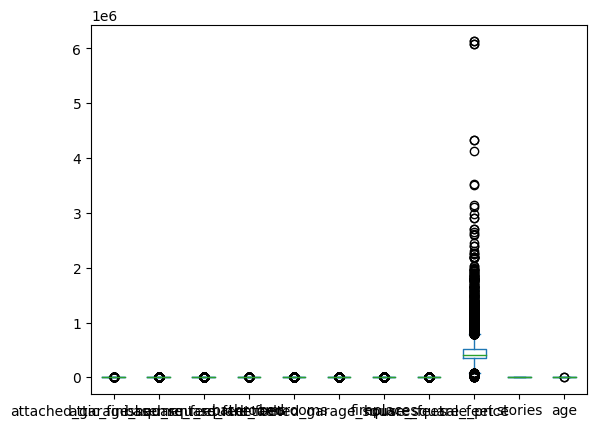

In [6]:
df.plot.box()

In [7]:
from sklearn.model_selection import train_test_split

def quick_tree(df,depth=5):
    # Resample and Process data:
    df_t = df.sample(n=df.shape[0],replace=True)
    y = df_t['sale_price']
    X = df_t.drop(['sale_price'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    # Fit decision tree:
    cart = tree.DecisionTreeRegressor(max_depth=depth) # Create a classifier object
    cart = cart.fit(X_test, y_test) # Fit the classifier
    # Visualize results:
    tree.plot_tree(cart,feature_names=X_train.columns.to_list(),filled=True)
    # Rsq:
    y_hat = cart.predict(X_test)
    SSE = np.sum( (y_test-y_hat)**2 )
    TSS = np.sum( (y_test-y_train.mean())**2 )
    Rsq = 1 - SSE/TSS
    print(Rsq)


0.6574133862770446


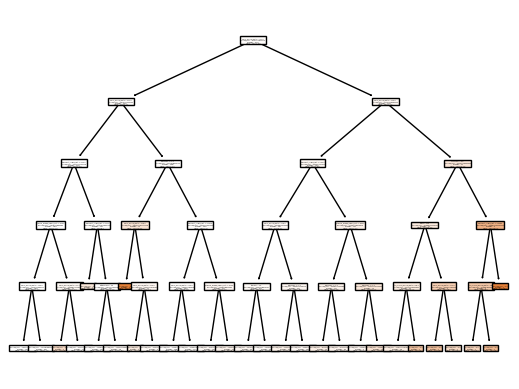

In [8]:
quick_tree(df)

0.641883858547456


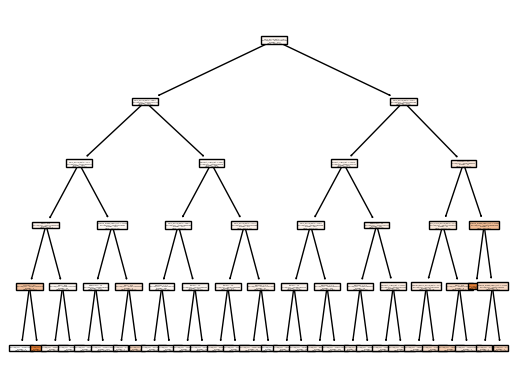

In [9]:
quick_tree(df)

## An Example of Model Fragility
- This can be pretty bad: The predictor variables change, the cutpoints change... This doesn't look like it is capturing real, robust features of the data, and metrics like the $R^2$ are often all over the place on out-of-sample/testing/validation data
- We are picking on the decision tree because it is a particular offender, but **this is a concern for any model with hyperparameters to fit**
- It appears that the out-of-the-box decision tree is just a bit too sensitive to the underlying features of the data
- If this kind of bootstrap resampling reveals a problem with the decision tree model, maybe it also suggests a solution?

## Ensembles and Bootstrap Aggregation
- We can easily take bootstrap samples of the original data and fit decision trees
- We can estimate a *set* of decision trees for a large number of bootstrap samples from the original data, called an **ensemble**, and then average them to get a predictor that is more robust
- This is called **bootstrap aggregation** or **bagging** or **model averaging**: We can take flawed models trained on random subsets of the data and combine them to improve overall performance
- The general name for this technique is **ensemble learning**
- Why? The WLLN implies convergence of averages, so let's average over models.

## Fitting an Ensemble

![Ensembles](https://github.com/DS3001/ensembles/blob/main/ensemble_construction.jpeg?raw=1)

## Predicting with an Ensemble

![Data Science](https://github.com/DS3001/ensembles/blob/main/ensemble_prediction.jpeg?raw=1)

## Example of Ensemble Learning
- Let's predict the sale price of a home using an ensemble of decision trees
- We'll use 100 trees built on 100 random bootstrap samples of the original data (This depends on the application, but we want it to run reasonably quickly for class purposes, so we'll constrain the max depth to a moderate value)
- Our goal is to compare the $R^2$ and variance of the individual trees versus the ensemble
- Some packages will automate this, but we'll do it "by hand" to be clear about how the idea is actually being implemented

In [10]:
# Split data into training rows and testing rows:
N = df.shape[0]
df = df.sample(frac=1, random_state=100) # randomize the order in which data appears
train_size = int(.8*N)
df_train = df[0:train_size]
N_train = df_train.shape[0]
df_test = df[train_size:]
N_test = df_test.shape[0]

# Bootstrap:
T = 1000
m_depth = 5
Rsq = np.zeros(T) # preallocate the rsq measure
y_test_hat = np.zeros([T,N_test]) # preallocate predictions on test set
df_train.head()

# Split data into train/test:
X_train = df_train.drop(['sale_price'],axis=1)
y_train = df_train['sale_price']
X_test = df_test.drop(['sale_price'],axis=1)
y_test = df_test['sale_price']

# Bootstrapping:
for s in range(T):
    # Generate a bootstrap sample:
    df_s = df_train.sample(frac=1, replace=True)
    X_s = df_s.drop('sale_price',axis=1)
    y_s = df_s['sale_price']
    # Fit decision tree:
    cart = tree.DecisionTreeRegressor(max_depth=m_depth) # Create a classifier object
    cart = cart.fit(X_s, y_s) # Fit the classifier
    # Compute Rsq:
    y_hat = cart.predict(X_test)
    SSE = np.sum( (y_test-y_hat)**2 )
    TSS = np.sum( (y_test-y_s.mean())**2 )
    Rsq[s] = 1 - SSE/TSS
    # Make and Save Predictions:
    y_test_hat[s,:] = y_hat

# Ensemble predictor:
y_hat_ensemble = y_test_hat.mean(axis=0) # Average the columns to get the ensemble prediction
SSE = np.sum( (y_test-y_hat_ensemble)**2 )
TSS = np.sum( (y_test-y_train.mean())**2 )
Rsq_ensemble = 1 - SSE/TSS

print(Rsq_ensemble)

0.45207353064120526


0.4487563343540395


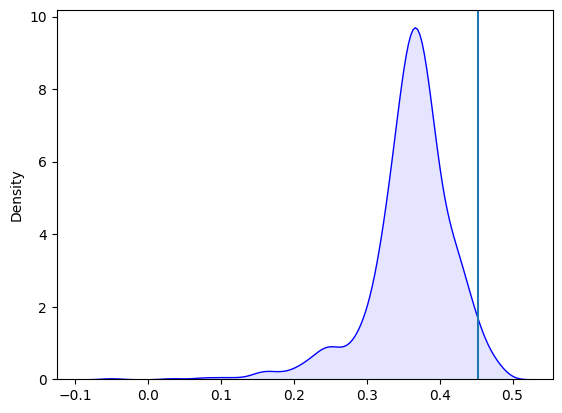

In [11]:
ax = sns.kdeplot(x = Rsq, fill = True, color = "blue", alpha = 0.1)
ax.axvline(x = Rsq_ensemble)

print(np.quantile(Rsq,.97))

Why bother with the ensemble
- might not do the same on the new data
- could overfit on the test set
- enemble model averages all the models - predictor that is stable and in the 97%

## Ensemble Advantage
- So the ensemble achieves an $R^2$ of .45 on the test set; it is in the roughly the 97th percentile of individual learners in terms of prediction
- More importantly, the ensemble predictor is **stable**: It is averaging over many draws of data, and because of the WLLN, adding more draws won't change its value a significant amount
- This didn't require a deep and complex strategy: Just averaging models over our bootstrap resampling

## Ensemble versus Individual Learners
- The ensemble $R^2$ is .410, while the average $R^2$ among the individual trees is .319: 29% better on the test data, and at the 95th percentile of predictors in the ensemble
- *The performance of the ensemble average is not the average of ensemble performance*
- When we bootstrap, the ensemble performs even better: Higher accuracy overall and less variance than the individual learners
- A big payoff is a massive reduction in prediction variance: Without increasing bias, we're making much less noisy predictions overall
- (This is one big payoff to learning about the LLN and bootstrapping: We're leveraging the power of the LLN to make higher quality predictions, and the bootstrap to evaluate the success)
- This is a big step towards "fixing" decision trees, but you can use the principle of ensemble learning

## Bagging ("Bootstrap Aggregation") and Classification
- We've assumed that we're doing regression and not classification: We averaged the predictions of each of the ensemble members to get an ensemble prediction, which only makes sense with regression
- When we're doing classification, we have each of the ensemble members "vote" on a category, and the category with the most votes from all the ensemble members wins

## Why stop there?
- Once you see this concept --- randomization can improve prediction algorithms by making them more robust --- you start noticing all kinds of places where data hiding or bootstrapping can be included
- Can we break the other decision tree problem: Over reliance on a small set of variables to the exclusion of many others?
- We'll also randomize which variables are offered to the decision tree algorithm for each bootstrap sample of the data at the time each split is made, to explore more nonlinear relationships between the features/predictor variables and target/outcome variable
- This leads to a powerful and popular tool: The Random Forest

## Random Forests
- A **random forest** is constructed by:
  1. Select a bootstrap sample from the data
  2. Fit a decision tree as normal, but at each split in the tree, select a random subset of features/predictors/variables to consider
  3. Repeat the above steps a large number of times
- To make a prediction, use all the trees in the forest and average the individual results for regression or take the most predicted category for classification
- This can be pretty computationally intensive (time to get a coffee or take a walk)

- seclect bootstrap sample and random subsetted features
- reduce correlation between trees so they are "experts" at differnt parts of the data
- overfitting averaged away

## Random Forests with `sklearn`


In [12]:
y_train.head()

13737    350000
16264    325000
15629    840000
2430     255000
4386     705000
Name: sale_price, dtype: int64

In [13]:
from sklearn.ensemble import RandomForestRegressor

# Fit model:
model = RandomForestRegressor() # Build a random forest model
rf = model.fit(X_train,y_train) # Fit the rf model

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions


<Axes: xlabel='sale_price'>

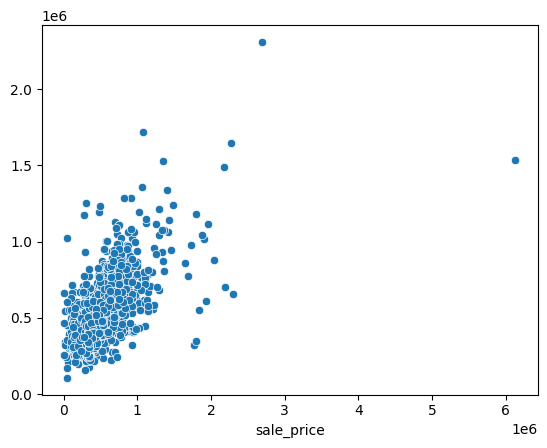

In [ ]:
# Scatterplot of predicted v. actual:
sns.scatterplot(x=y_test, y=y_hat_rf) # Predicted v Actual

# ADVANTAGE:
range of value it predicts are closer to that the data giver, unlike regression which pushes values together into a bellcurve  

<Axes: xlabel='sale_price', ylabel='Density'>

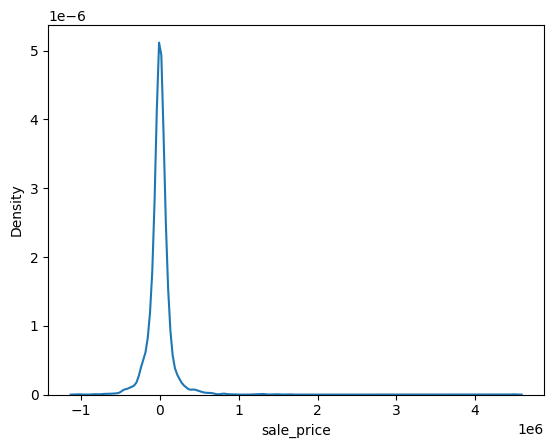

In [14]:
# Residual plot:
residual = y_test - y_hat_rf
sns.kdeplot(x=residual)

In [15]:
rf.score(X_test,y_test) # Rsq measure

0.4702978851954618

## Classification
- We talked about regression today, but you can obviously do this with classification
- Instead of predicting a numeric value, each weak learner predicts a categorical value
- The weak learners "vote" over the winning prediction

## Explainability, Interpretability
- We're reaching a point where the models become hard to explain to people and hard for us to interpret
- A model is **explainable** if the mapping from inputs to predictions can be understood by human intelligence (how does the model use inputs/data to create predictions?)
- A model is **interpretable** if any prediction can be rationalized from the data and model by human intelligence (why is the model making this particular prediction?)
- I am not sure these terms are well-defined
- The random forest is the first model that probably isn't explainable or interpretable in these terms, since it aggregates many models trained on randomly generated subsets of data

- can we trust and understand models
- random forests are not really interpretable - would need to know the thousands of decisions and pieces involved
- random forests may be explainable - probably more at a high level, not every little decision and weight and part
 - like chat GPT

## Variable Importance
- But our human minds prefer (demand?) interpretable output: A regression coefficient table, a dendrogram, etc.
- Since the random forest is an average of hundreds of randomly constructed objects, most of these interpretability tools are not useful
- Many times, people report **variable importance** as a way of suggesting which variables ended up being the most useful for the process of constructing the forest
- How do you interpret variable importance? It is the total amount by which Gini impurity/Entropy is reduced when this variable is used across all trees in the ensemble
- This is measured in impurity, **not** the impact on the predictions (like a regression coefficient)

Text(24.000000000000007, 0.5, 'Mean decrease in impurity')

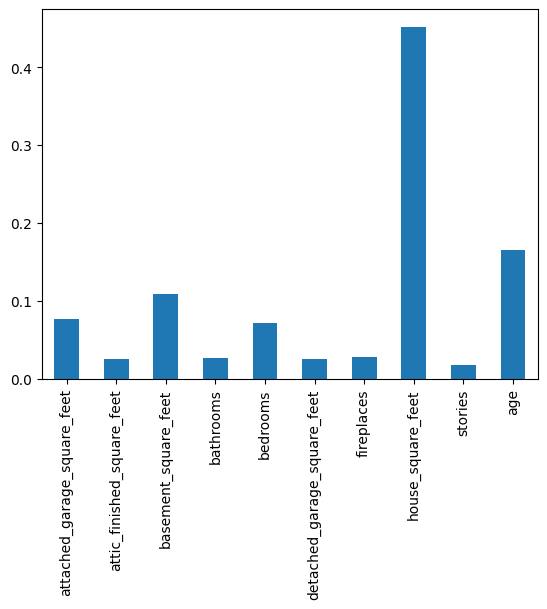

In [16]:
# Variable importance plot:
forest_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
forest_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity")

## Gradient Boosting
- The other ensemble learning method that we won't talk about is called *Gradient Boosting*
- A problem with decision trees is how much information they fail to use: Binary, greedy splits can end up using the same variable or subset of variables extensively, without touching others
- Instead, take the residual from one decision tree, and use it as the target/outcome variable for a second set of models
- This is danger zone overfitting territory, but can be done in thoughtful and powerful ways, like extreme gradient boosting (e.g. `XGBoost`)

- danger zone for overfitting a model

## Ensembles
- Ensemble learning can improve the performance of any kind of base learner (e.g. decision trees, linear models) through "bootstrap aggregation" (model averaging)
- These ideas can also motivate more complex uses of randomization to improve performance: The intuition is to make the ensemble members as uncorrelated as possible, but still trained on the same data, so their different predictions end up complementing one another
- The Random Forest is a complex and computationally intensive algorithm, but it resolves the fragility problem for decision-trees by using bootstrap aggregation and random feature selection
- This is the first payoff of adopting a more probabilistic perspective on the data

## Conclusion
- The ideas of ensembles, the random forest algorithm, and some idea that gradient boosting exists arguably puts you into the modern world of machine learning (like, the last 20 years)
- The last model we have our sights set on is called the LASSO: Least Asymptotic Shrinkage and Selection Operator
- The basic idea of the LASSO is: How do you pick regressors to build a well-performing linear model?